## Imports and Drive Mounting

In [ ]:
import numpy as np
import pandas as pd
from PIL import Image
import os
import glob
import cv2
import random
import shutil
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import gc
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img
import tqdm.notebook as tq
from sklearn.metrics import accuracy_score
import tensorflow as tf
from google.colab import output
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout

Using TensorFlow backend.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Copying data from Kaggle

In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/My Drive/Colab Notebooks/DMML2/KaggleData"

In [ ]:
# Changing working directory

%cd /content/drive/My Drive/Colab Notebooks/DMML2/KaggleData

/content/drive/My Drive/Colab Notebooks/DMML2/KaggleData


In [ ]:
!kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

 99% 603M/612M [00:08<00:00, 73.6MB/s]
100% 612M/612M [00:08<00:00, 72.2MB/s]


## Unzipping Kaggle data to Dataset folder.


In [ ]:
# Changing working directory

%cd /content/drive/My Drive/Colab Notebooks/DMML2/KaggleData

/content/drive/My Drive/Colab Notebooks/DMML2/KaggleData


In [ ]:
# Checking and removing the files present in Dataset folder before unzipping the new files.
# Take almost 11 mins.
### Uncommment below
# %%time
# shutil.rmtree('../Dataset/', ignore_errors=True)
### Uncomment above
# def rmtree(directory):
#     for root, dirs, files in os.walk(directory, topdown=False):
#         for file in files:
#             os.remove(os.path.join(root, file))
#         for dir in dirs:
#             os.rmdir(os.path.join(root, dir))
#     os.rmdir(directory)

# rmtree('../Dataset/') if os.path.isdir('../Dataset/') else print("No Directory")

CPU times: user 4.19 s, sys: 4.49 s, total: 8.67 s
Wall time: 10min 21s


In [ ]:
# Unzipping kaggle files.
# Take almost 26 mins.

%%time
!unzip '/content/drive/My Drive/Colab Notebooks/DMML2/KaggleData/gtsrb-german-traffic-sign.zip' -d '/content/drive/My Drive/Colab Notebooks/DMML2/Dataset'


Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/My Drive/Colab Notebooks/DMML2/Dataset/train/5/00005_00053_00013.png  
  inflating: /content/drive/My Drive/Colab Notebooks/DMML2/Dataset/train/5/00005_00053_00014.png  
  inflating: /content/drive/My Drive/Colab Notebooks/DMML2/Dataset/train/5/00005_00053_00015.png  
  inflating: /content/drive/My Drive/Colab Notebooks/DMML2/Dataset/train/5/00005_00053_00016.png  
  inflating: /content/drive/My Drive/Colab Notebooks/DMML2/Dataset/train/5/00005_00053_00017.png  
  inflating: /content/drive/My Drive/Colab Notebooks/DMML2/Dataset/train/5/00005_00053_00018.png  
  inflating: /content/drive/My Drive/Colab Notebooks/DMML2/Dataset/train/5/00005_00053_00019.png  
  inflating: /content/drive/My Drive/Colab Notebooks/DMML2/Dataset/train/5/00005_00053_00020.png  
  inflating: /content/drive/My Drive/Colab Notebooks/DMML2/Dataset/train/5/00005_00053_00021.png  
  inflating: /content/drive/My Drive/Colab Notebooks/DMML2

## Train and Test Images are read, converted into array and saved the array as .npy file

In [ ]:
# Changing working directory

%cd /content/drive/My Drive/Colab Notebooks/DMML2/KaggleData

In [ ]:
# Paths and parameters.

train_data_path = '../NumpyArrays/Cells.npy'
train_label_path = '../NumpyArrays/labels.npy'
test_data_path = '../NumpyArrays/Cells_test.npy'
test_label_path = '../NumpyArrays/labels_test.npy'

height = 30
width = 30
channels = 3
classes = 43
n_inputs = height*width*channels

In [ ]:
# Reading the input images and putting them into a numpy array

data=[]
labels=[]

for i in range(classes):
    path = "../Dataset/Train/{0}/".format(i)
    print(path)
    Class=os.listdir(path)
    bar = tq.tqdm(range(len(Class)))
    for j in bar:
        try:
            image=cv2.imread(path+Class[j])
            image_from_array = Image.fromarray(image, 'RGB')
            size_image = image_from_array.resize((height, width))
            data.append(np.array(size_image))
            labels.append(i)
        except AttributeError:
            print(" ")
    output.clear()

In [ ]:
len(data)

39209

In [ ]:
# Converting lists into numpy arrays.

Cells=np.array(data)
labels=np.array(labels)

In [ ]:
# Saving arrays in a file.

np.save(train_data_path, Cells)
np.save(train_label_path, labels)

In [ ]:
# Clearing memory.

del data
del Cells
del labels

gc.collect()

383

In [ ]:
# Loading test data.

y_test=pd.read_csv("../Dataset/Test.csv")
labels=y_test['Path']
y_test=y_test['ClassId'].values

data=[]

for f in tq.tqdm(range(len(labels))):
    # print(labels[f])
    image=cv2.imread('../Dataset/'+labels[f])
    image_from_array = Image.fromarray(image, 'RGB')
    size_image = image_from_array.resize((height, width))
    data.append(np.array(size_image))


In [ ]:
len(data)

12630

In [ ]:
# Converting test data to arrays.

X_test=np.array(data)
y_test=np.array(y_test)

In [ ]:
# Saving test data array to files.

np.save(test_data_path, X_test)
np.save(test_label_path, y_test)

In [ ]:
# Clearing memory.

del data
del X_test
del y_test

gc.collect()

65

# CNN Model

In [ ]:
# Loading Train Data.

Cells = np.load(train_data_path)
labels = np.load(train_label_path)

In [ ]:
# Randomize the order of the input images

s=np.arange(Cells.shape[0])
np.random.seed(43)
np.random.shuffle(s)
Cells=Cells[s]
labels=labels[s]

In [ ]:
# Spliting the images into train and validation sets
(X_train,X_val)=Cells[(int)(0.2*len(labels)):],Cells[:(int)(0.2*len(labels))]

X_train = X_train.astype('float32')/255 
X_val = X_val.astype('float32')/255

(y_train,y_val)=labels[(int)(0.2*len(labels)):],labels[:(int)(0.2*len(labels))]

In [ ]:
# Using one hote encoding for the train and validation labels

y_train = to_categorical(y_train, 43)
y_val = to_categorical(y_val, 43)

In [ ]:
# Definition of the DNN model

model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=X_train.shape[1:]))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(43, activation='softmax'))

In [ ]:
#Compilation of the model

model.compile(
    loss='categorical_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy']
)

In [ ]:
#using ten epochs for the training and saving the accuracy for each epoch

epochs = 20
history = model.fit(X_train, y_train, batch_size=32, epochs=epochs,
validation_data=(X_val, y_val))

Train on 31368 samples, validate on 7841 samples
Epoch 1/20
31368/31368 [==============================] - 14s 432us/step - loss: 1.2544 - accuracy: 0.6430 - val_loss: 0.1651 - val_accuracy: 0.9587
Epoch 2/20
31368/31368 [==============================] - 6s 194us/step - loss: 0.2243 - accuracy: 0.9315 - val_loss: 0.0544 - val_accuracy: 0.9880
Epoch 3/20
31368/31368 [==============================] - 6s 198us/step - loss: 0.1394 - accuracy: 0.9571 - val_loss: 0.0438 - val_accuracy: 0.9888
Epoch 4/20
31368/31368 [==============================] - 6s 198us/step - loss: 0.1031 - accuracy: 0.9681 - val_loss: 0.0391 - val_accuracy: 0.9907
Epoch 5/20
31368/31368 [==============================] - 6s 197us/step - loss: 0.0875 - accuracy: 0.9730 - val_loss: 0.0252 - val_accuracy: 0.9944
Epoch 6/20
31368/31368 [==============================] - 6s 196us/step - loss: 0.0741 - accuracy: 0.9772 - val_loss: 0.0286 - val_accuracy: 0.9940
Epoch 7/20
31368/31368 [==============================] - 6s 1

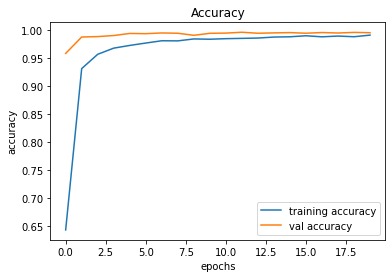

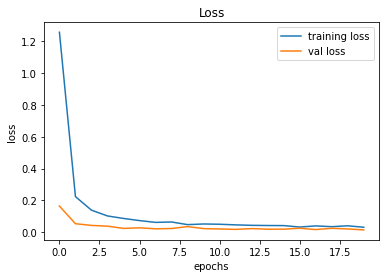

In [ ]:
# Creating plots

plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

In [ ]:
# Loading test data from saved files.

X_test = np.load(test_data_path)
y_test = np.load(test_label_path)

In [ ]:
X_test = X_test.astype('float32')/255 

In [ ]:
# Predicting output.

pred = model.predict_classes(X_test)

In [ ]:
# Checking accuracy of predictions.

accuracy_score(y_test, pred)

0.9732383214568487

## Trying with 30, 50 own dataset (Attempt Failed: Accuracy 49.5%).


In [ ]:
# thirty_path = "./30_50_OwnData/30/"
# fifty_path = "./30_50_OwnData/50/"

# mergedfiles_path = './30_50_OwnData/MergedFiles/'

mergedfiles_path = '/content/drive/My Drive/Colab Notebooks/Traffic Sign/MergedFiles'

In [ ]:
#Checking if the directory exists.
os.path.isdir(mergedfiles_path)

# Deleting the directory.
shutil.rmtree(mergedfiles_path)

In [ ]:
# Unzipping files to the directory as a fresh start.

%%time

!unzip '/content/drive/My Drive/Colab Notebooks/Traffic Sign/MergedFiles.zip' -d '/content/drive/My Drive/Colab Notebooks/Traffic Sign'

In [ ]:
# Activating GPU
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
# Renamed images and moved to the train folder from 30 folder.
i = 1
for filename in glob.iglob(thirty_path + '*', recursive=True):
    filename = filename.replace("\\", "/")
    shutil.move(filename, mergedfiles_path+'thirty_{}.png'.format(i))
    i += 1

In [ ]:
# Renamed images and moved to the train folder from 50 folder.

i = 0
for filename in glob.iglob(fifty_path + '*', recursive=True):
    filename = filename.replace("\\", "/")
    shutil.move(filename, mergedfiles_path+'fifty_{}.png'.format(i))
    i += 1

In [ ]:
# listed the names of files in train folder.

all_files = os.listdir(mergedfiles_path)
len(all_files)

4470

In [ ]:
# Let's shuffle the list of all the files

random.shuffle(all_files)

In [ ]:
# function to read and process the images.

def read_process_images(filenames, width, height, path):
    X = []
    y = []
    count = 0
    for i in tq.tqdm(range(len(filenames))):
        img = cv2.imread(path+'/'+filenames[i], cv2.IMREAD_COLOR)
        X.append(cv2.resize(img, (width, height), interpolation=cv2.INTER_CUBIC))
        # print(count)
        
        if 'thirty' in filenames[i]:
            y.append(1)
        elif 'fifty' in filenames[i]:
            y.append(0)
        else:
            y.append('')
        count += 1
    return X, y
    

In [ ]:
X, y = read_process_images(all_files, 75, 75, mergedfiles_path)

In [ ]:
X[0]

array([[[156, 142,  98],
        [186, 166, 134],
        [215, 191, 179],
        ...,
        [255, 255, 247],
        [255, 255, 244],
        [255, 255, 246]],

       [[122, 116,  76],
        [141, 136, 104],
        [172, 162, 144],
        ...,
        [176, 174, 167],
        [162, 162, 154],
        [154, 156, 148]],

       [[155, 144, 107],
        [155, 145, 112],
        [170, 156, 128],
        ...,
        [ 87,  86,  88],
        [ 79,  79,  81],
        [ 75,  76,  78]],

       ...,

       [[ 45,  47,  40],
        [ 35,  37,  33],
        [ 27,  29,  28],
        ...,
        [ 54,  60,  65],
        [ 51,  57,  64],
        [ 49,  55,  64]],

       [[ 41,  44,  36],
        [ 33,  36,  31],
        [ 27,  30,  29],
        ...,
        [ 54,  59,  64],
        [ 48,  54,  59],
        [ 48,  54,  60]],

       [[ 39,  43,  36],
        [ 32,  36,  32],
        [ 26,  30,  29],
        ...,
        [ 50,  54,  60],
        [ 50,  55,  61],
        [ 48,  54,  61]]

In [ ]:
y[0]

0

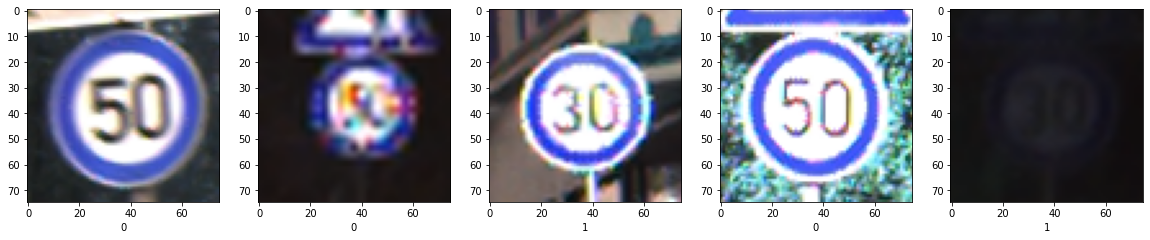

In [ ]:
plt.figure(figsize=(20,10))
columns = 5
for i in range(columns):
    plt.subplot(5 / columns + 1, columns, i+1)
    plt.imshow(X[i])
    plt.xlabel(y[i])

In [ ]:
# Let's clear memory by deleting unnecessary variables.

del all_files

gc.collect()

11976

In [ ]:
# Let's check how many classes of images we have.

print("Thirty: ", y.count(1))
print("Fifty: ", y.count(0))
print("Other: ", y.count(''))

Thirty:  2220
Fifty:  2250
Other:  0


In [ ]:
# Let's convert lists to arrays and check the shape.

X = np.array(X)
y = np.array(y)

print("Shape of images is: ", X.shape)
print("Shape of lables is: ", y.shape)

Shape of images is:  (4470, 75, 75, 3)
Shape of lables is:  (4470,)


In [ ]:
# Let's separate 25% data for testing.

X, X_test, y, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
print("Information of Test Data")
print("")

print("Shape of images is: ", X_test.shape)
print("Shape of lables is: ", y_test.shape)
print("")

print("Thirty: ", list(y_test).count('T'))
print("Fifty: ", list(y_test).count('F'))
print("Other: ", list(y_test).count(''))

Information of Test Data

Shape of images is:  (1118, 75, 75, 3)
Shape of lables is:  (1118,)

Thirty:  0
Fifty:  0
Other:  0


In [ ]:
# Let's split X, y in train and validation subsets.

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42)

In [ ]:
print("Information of Train Data")
print("")

print("Shape of images is: ", X_train.shape)
print("Shape of lables is: ", y_train.shape)
print("")

print("Thirty: ", list(y_train).count('T'))
print("Fifty: ", list(y_train).count('F'))
print("Other: ", list(y_train).count(''))

Information of Train Data

Shape of images is:  (2849, 75, 75, 3)
Shape of lables is:  (2849,)

Thirty:  0
Fifty:  0
Other:  0


In [ ]:
print("Information of Validation Data")
print("")

print("Shape of images is: ", X_val.shape)
print("Shape of lables is: ", y_val.shape)
print("")

print("Thirty: ", list(y_val).count('T'))
print("Fifty: ", list(y_val).count('F'))
print("Other: ", list(y_val).count(''))

Information of Validation Data

Shape of images is:  (503, 75, 75, 3)
Shape of lables is:  (503,)

Thirty:  0
Fifty:  0
Other:  0


In [ ]:
# Let's clear some memory

del X
del y

gc.collect()

0

In [ ]:
# Length of train and validation set
ntrain = len(X_train)
nval = len(X_val)

# Let's consider the batch size as 32 for the model building.
batch_size = 32


In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(75, 75, 3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model.compile(
    loss='binary_crossentropy', 
    optimizer=optimizers.RMSprop(lr=1e-4), 
    metrics=['acc']
)

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,)

val_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
val_generator = val_datagen.flow(X_val, y_val, batch_size=batch_size)

In [ ]:
#using ten epochs for the training and saving the accuracy for each epoch

history = model.fit(train_generator,
                    steps_per_epoch = ntrain // batch_size,
                    epochs= 128,
                    validation_data=val_generator,
                    validation_steps=nval // batch_size)

Epoch 1/128
89/89 [==============================] - 4s 46ms/step - loss: 0.2030 - acc: 0.9152 - val_loss: 0.1065 - val_acc: 0.9792
Epoch 2/128
89/89 [==============================] - 4s 45ms/step - loss: 0.1978 - acc: 0.9283 - val_loss: 0.0380 - val_acc: 0.9660
Epoch 3/128
89/89 [==============================] - 4s 45ms/step - loss: 0.1815 - acc: 0.9311 - val_loss: 0.0644 - val_acc: 0.9830
Epoch 4/128
89/89 [==============================] - 4s 44ms/step - loss: 0.1799 - acc: 0.9272 - val_loss: 0.0192 - val_acc: 0.9703
Epoch 5/128
89/89 [==============================] - 4s 44ms/step - loss: 0.1655 - acc: 0.9386 - val_loss: 0.1589 - val_acc: 0.9490
Epoch 6/128
89/89 [==============================] - 4s 45ms/step - loss: 0.1808 - acc: 0.9333 - val_loss: 0.0319 - val_acc: 0.9830
Epoch 7/128
89/89 [==============================] - 4s 46ms/step - loss: 0.1767 - acc: 0.9326 - val_loss: 0.0174 - val_acc: 0.9788
Epoch 8/128
89/89 [==============================] - 4s 44ms/step - loss: 0.

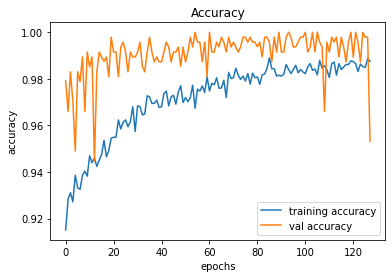

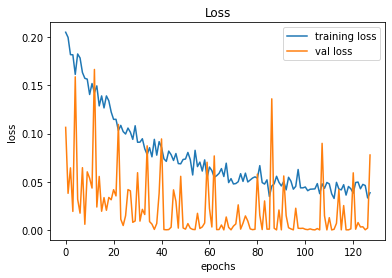

In [ ]:
# Display of the accuracy and the loss values

import matplotlib.pyplot as plt

plt.figure(0)
plt.plot(history.history['acc'], label='training accuracy')
plt.plot(history.history['val_acc'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

In [ ]:
# Let's predict the test images.

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow(X_test, batch_size=1)

In [ ]:
i = 0
text_labels = []
# plt.figure(figsize=(30,20))

for i in tq.tqdm(range(len(test_generator))): 
  pred = model.predict(test_generator[i])
  if pred > 0.5:
    text_labels.append(0)
  else:
    text_labels.append(1)



In [ ]:
accuracy_score(y_test, text_labels)

0.49552772808586765